In [1]:
import random
from os import sep, listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np 
from scipy import ndimage
import skimage.transform as tr
from scipy.io import loadmat, savemat
from configparser import ConfigParser
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA 
from sklearn.mixture import GaussianMixture
from configparser import ConfigParser
import skfuzzy as skf
import spectral as sp
import shapefile as sf
import pandas as pd
import shapefile
import cv2

plt.style.use('ggplot')

d:\anaconda3\envs\crowns\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


### Getting Hyperspectral and LiDAR chm .mat files 
Ensure The dataset has been fetched and processed 


In [2]:
config = ConfigParser() 
config.read('appconfig.ini')
DATASET_PATH = 'ECODSEdataset' + sep + 'ECODSEdataset'+ sep + 'RSdata'+ sep 
LIDAR_FOLDER_PATH = DATASET_PATH + 'chm' + sep + 'MAT' + sep 
HYPER_FOLDER_PATH = DATASET_PATH + 'hs'  + sep + 'MAT' + sep 
HYPER_BANDS_FILE = 'ECODSEdataset' + sep + 'ECODSEdataset' + sep + 'hyper_bands.csv'

try: 
    lidar_files = sorted([lidar_file for lidar_file in 
                 [f for f in listdir(LIDAR_FOLDER_PATH) if isfile(join(LIDAR_FOLDER_PATH, f))]])
    hyper_files = sorted([hyper_file for hyper_file in 
                 [f for f in listdir(HYPER_FOLDER_PATH) if isfile(join(HYPER_FOLDER_PATH, f))]])
    hyper_bands = pd.read_csv(HYPER_BANDS_FILE)
except FileNotFoundError: 
    print("Failed to find Processed Dataset.\nPlease follow the README instructions to fetch and process the dataset")


### Dimensionality Reduction for Hyperspectral Images

In [3]:
def trim_bands(source_list, filter_list):
    trimmed = []
    for i in range(len(filter_list)):
        if filter_list[i] == 0:
            trimmed.append(source_list[i])
    return trimmed[:]

def purge_noisy_bands(image, band_filter):
    out = np.zeros([80,80,369])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            out[i][j] = trim_bands(image[i][j], band_filter)
    return out

In [4]:
wavelengths = hyper_bands['Band_nanometers']
noise_flags = hyper_bands['Noise_flag']
trim_wavelengths = trim_bands(wavelengths, list(noise_flags))
trim_wavelengths = trim_wavelengths[:len(trim_wavelengths)- int(config['RED_DIM']['CLEAR_END_BANDS'])]
len(trim_wavelengths)

364

In [6]:
hyper_files[2]

'OSBS_003_hyper.mat'

### Plotting Functions

In [5]:
def plot_chm(im):
    cmap = cm.get_cmap('afmhot', 4)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=1, origin='lower')
    plt.title("LiDAR Heat Map")
    plt.colorbar(ticks=np.linspace(0,1,5))
    plt.show()

def plot_hyper(im):
    sp.imshow(im, origin="lower")
    
def plot_hyper_bands(im, pixel_x, pixel_y, wavelengths=trim_wavelengths, marker=0):
    f, ax = plt.subplots(1,1)
    ax.set_xlabel('band_nanometers')
    ax.set_ylabel('Intensity')
    ax.plot(wavelengths[marker:], im[pixel_x][pixel_y][marker:])
    ax.set_title('Hyperspectral Intensity for a band')
#     f.savefig('BeforeNoiseReduction.png')
    plt.show()

#### Hyperspectral Image Bands without any processing

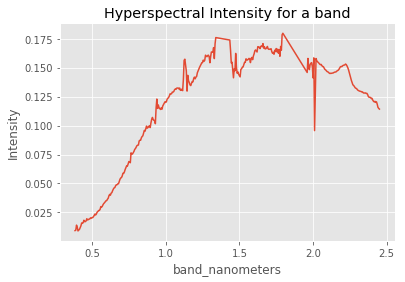

In [6]:
hyper_image = loadmat(HYPER_FOLDER_PATH + hyper_files[3])['image'] 
old_image = loadmat(DATASET_PATH + 'hs'  + sep + 'backup' + sep + 'OSBS_005_hyper.mat')['image'] 
# mat2_image = loadmat(DATASET_PATH + 'hs'  + sep + 'MAT2' + sep + 'OSBS_005_hyper.mat')['image']
another_image =  loadmat(HYPER_FOLDER_PATH + hyper_files[2])['image'] 
plot_hyper_bands(hyper_image, pixel_x=40, pixel_y=25, wavelengths=trim_wavelengths)

In [7]:
orig_image = loadmat(DATASET_PATH + 'hs'  + sep + 'MAT-Orig' + sep + hyper_files[2])['image']

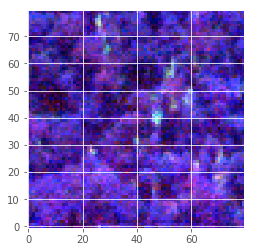

In [9]:
orig_image.shape
plot_hyper_bands()

In [151]:
# plt.plot(loadmat(HYPER_FOLDER_PATH + hyper_files[3])['image'][40][25], hyper_bands['Band_nanometers'])
# plt.show()

#### Using the Band Filter in Data set to reduce dimensionality

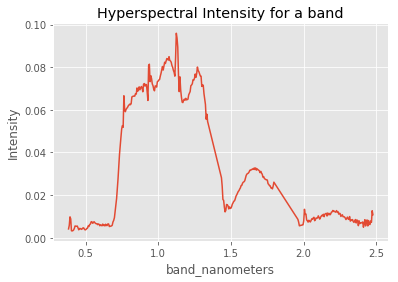

In [39]:
# wavelengths = hyper_bands['Band_nanometers']
noise_flags = hyper_bands['Noise_flag']
trimmed = old_image[40][25]
plt.style.use('ggplot')
f, ax = plt.subplots(1,1)
ax.set_xlabel('band_nanometers')
ax.set_ylabel('Intensity')
ax.plot(trim_wavelengths, trimmed)
ax.set_title('Hyperspectral Intensity for a band')
# f.savefig('AfterNoiseReduction.png')
plt.show()

In [40]:
def smoothen(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

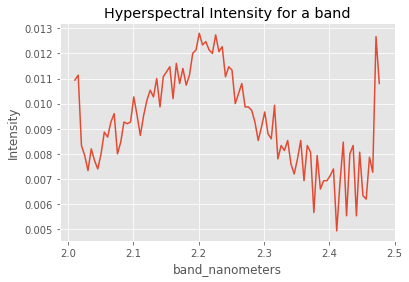

In [41]:
f, axes = plt.subplots(1,1)
axes.set_xlabel('band_nanometers')
axes.set_ylabel('Intensity')
axes.set_title('Hyperspectral Intensity for a band')
axes.plot(trim_wavelengths[275:], trimmed[275:])
plt.savefig('squiggly.png')
plt.show()

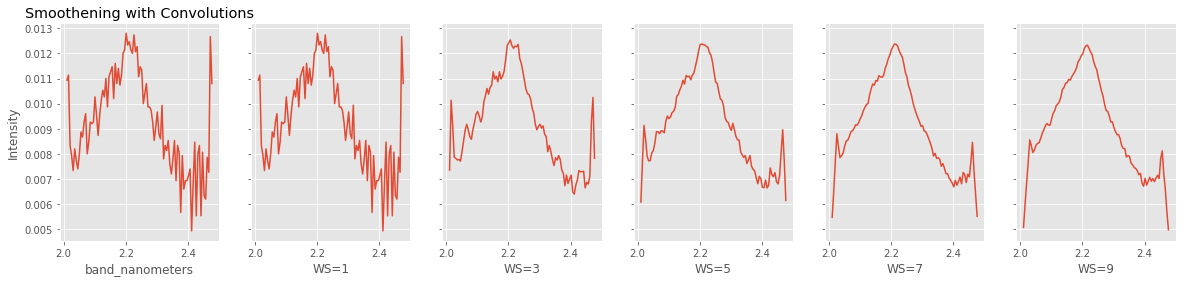

In [208]:
noisy = trimmed[275:]
f, axes = plt.subplots(1,6, sharey=True, figsize=(20,4))
axes[0].set_xlabel('band_nanometers')
axes[0].set_ylabel('Intensity')
axes[0].set_title('Smoothening with Convolutions')
axes[0].plot(trim_wavelengths[275:], trimmed[275:])
for i in range(5):
    axes[i+1].set_xlabel('WS=%d' % (2*i+1))
    axes[i+1].plot(trim_wavelengths[275:], smoothen(trimmed[275:], 2*i+1))
plt.savefig('smooth.png')
plt.show()

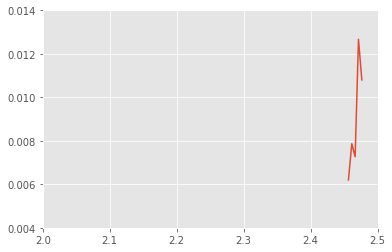

In [180]:
marker = 364
plt.xlim(2.0,2.5)
plt.ylim(0.004,0.014)
plt.plot(trim_wavelengths[marker:],  smoothen(trimmed[marker:], 1))
plt.show()

369 364


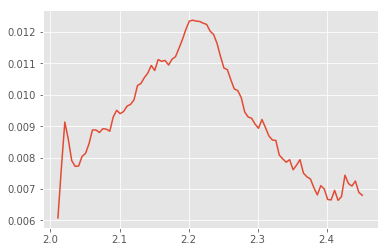

In [235]:
pos = 275 
clear_bands = 5
trimmed = old_image[40][25]
upper_limit = trimmed.shape[0] - clear_bands
print(trimmed.shape[0] ,upper_limit)
smoothed_image = np.append(trimmed[:pos], smoothen(trimmed[pos:], 5))[:upper_limit]
marker = 275
# averaged_value = np.average(smoothed_image[marker:])
# for i in range(marker, smoothed_image.shape[0]):
#     smoothed_image[i] = averaged_value
plt.plot(trim_wavelengths[marker:upper_limit], smoothed_image[marker:])
plt.show()

In [236]:
# np.append(trimmed[:275], smoothen(trimmed[275:], 5)).shape
smoothed_image.shape[0]

364

In [43]:
# out_image = purge_noisy_bands(hyper_image, noise_flags)

In [44]:
len(noise_flags[noise_flags == 1])

57

(38,) (38,) 408339.91918347526 3285361.056867598 408346.927410692 3285369.94311345
(17,) (17,) 408346.1498209979 3285357.0149257784 408350.9890494279 3285362.8540105303
(12,) (12,) 408335.04363294935 3285355.9348182133 408338.0379024188 3285359.1958253165
(16,) (16,) 408351.65906279685 3285349.6772811664 408357.05376401223 3285355.0521766515
(15,) (15,) 408361.23845431756 3285353.8624865296 408366.3732301792 3285357.114521814
(15,) (15,) 408340.81592134864 3285337.8988223975 408344.8257782392 3285343.0084229056
(11,) (11,) 408343.9195441014 3285342.0595969143 408347.8025233365 3285346.226354544


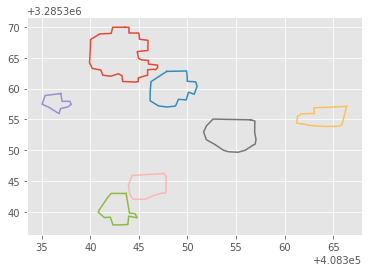

In [124]:
sf = shapefile.Reader("ITC_OSBS_003.shp")

# print("Initializing Display")
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.xlim([76, 85])
# plt.ylim([12, 21])
# print("Display Initialized")
# max_norm = float('-inf')
# for shape in sf.shapes(): 
#     x = np.array([i[0] for i in shape.points[:]])
#     y = np.array([i[1] for i in shape.points[:]])
#     max_norm = max(max_norm, x.max(), y.max())

for shape in sf.shapes():
    x = np.array([i[0] for i in shape.points[:]])
    # x /= 3285346.226354544
#     x /= max_norm
    y = np.array([i[1] for i in shape.points[:]])
#     y /= max_norm
#     print(x,y)
    plt.plot(x,y)
    print(x.shape,y.shape, min(x), min(y), max(x), max(y))
#     plt.axes.
plt.savefig('ShapeOut.png')
plt.show()


## Clustering Main Code

In [26]:
def k_means_clustering(inp_image, n_clusters=2):
    if inp_image is None:
        print("Empty Input. Exiting")
        return None 
    # Create K Means Model 
    k_means = KMeans(n_clusters=n_clusters)
    shape = inp_image.shape
    # Fit on Input Image 
    k_means.fit(inp_image.flatten().reshape(shape[0]*shape[1],shape[2]))
    # Get Cluster Labels
    clust = k_means.labels_.astype(float)

    return clust.reshape(shape[0],shape[1])


def fuzzy_c_means(inp_image, n_clusters=2):
    if inp_image is None:
        print("Empty Input. Exiting")
        return 
    
    shape = inp_image.shape
    # Create and Train on FCM Model 
    centers, u, u0, d, jm, n_iters, fpc = skf.cluster.cmeans(
        inp_image.flatten().reshape(shape[0]*shape[1],shape[2]).T,
        c=n_clusters,
        m=float(config['FCM']['FUZZ_DEGREE']),
        error=float(config['FCM']['ERROR']),
        maxiter=int(config['FCM']['MAX_ITER']),
        init=None,
        seed=int(config['FCM']['SEED'])
    )
    # Get Cluster Labels with Max Porbability 
    clust = np.argmax(u, axis=0).astype(float)
    
    return clust.reshape(shape[0],shape[1])


def gaussian_mixture_model(inp_image, n_clusters=2):
    shape = inp_image.shape
    inp_image = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    # Create Gaussian Mixture Model with Config Parameters
    gmm = GaussianMixture(
        n_components=n_clusters, covariance_type=config['GMM']['COVARIANCE_TYPE'],
        max_iter=int(config['GMM']['MAX_ITER']), random_state=int(config['GMM']['RANDOM_STATE']))
    # Fit on Input Image
    gmm.fit(X=inp_image)
    # Get Cluster Labels 
    clust = gmm.predict(X=inp_image)
    
    return clust.reshape(shape[0],shape[1])
   
def spectral_cluster(inp_image, n_clusters=2):
    original_shape = inp_image.shape
    downsampled_img = pyramid_reduce(inp_image,3)
    shape = downsampled_img.shape
    downsampled_img = downsampled_img.reshape(shape[0]*shape[1], shape[2])
    sp = SpectralClustering(n_clusters=n_clusters,
                               eigen_solver=config['SPECTRAL']['EIGEN_SOLVER'],
                               affinity=config["SPECTRAL"]["AFFINITY"])
    sp.fit_predict(downsampled_img)
    clust = sp.labels_
    clust = clust.reshape(shape[0],shape[1])
    # Performimg kmeans to re generate clusters after resize, original segmentation remains intact.
    clust =  k_means_clustering(n_clusters,resize(clust,(original_shape[:-1])).reshape((original_shape[:-1])+(1,)))
    return clust
    
def SOM(inp_image, n_clusters=5, n_job=5, map_dim=20):

    # Calculate the map
    mapsize = [map_dim,map_dim]
    shape = inp_image.shape
    data = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    som = sompy.SOMFactory.build(data, mapsize)  
    som.train(n_job=n_job, verbose=None)
    
    #calculating clusters
    cl = som.cluster(n_clusters=n_clusters)
    
    # calculating which pixel is associated which cluster
    project_data = som.project_data(data)
    clust = np.zeros((shape[0], shape[1]))
    for i, q in enumerate(project_data):
        temp = cl[q]
        clust[np.unravel_index(i, dims=((shape[0], shape[1])))] = temp

    return clust

def connected_compoments(clustered):
    new = np.zeros(clustered.shape+(2,))
    for i in np.unique(clustered):
        CCIm, nr_objects = ndimage.label((clustered ==i)*1)
        for index, value in np.ndenumerate(CCIm):
            if value !=0:
                new[index] = temp= [i, value]
    return new

def postprocess(inp_image):
    # Median filter as a post processing step to remove small clusters.
    window_size = int(config['MEDIAN_FILTER']['WINDOW_SIZE'])
    return ndimage.median_filter(inp_image, size=window_size)

In [36]:
another_image.shape 

(80, 80, 364)

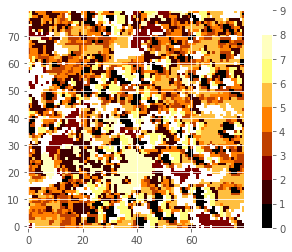

In [29]:
def label_show(im):
    cmap = cm.get_cmap('afmhot', 9)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=9,origin='lower')
    plt.colorbar(ticks=np.linspace(0,9,10))
    plt.show()


# n_components = int(config['HYPER']['N_COMPONENTS'])
# image = hyper_image 
# shape = image.shape 
# hyper = image.flatten().reshape(shape[0]*shape[1],shape[2])
# # print(hyper.shape)
# pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
# reduced_image = pca.transform(hyper).reshape(shape[0],shape[1],n_components)
# print(reduced_image.shape, image.shape)
out_labels = k_means_clustering(image, 10)
label_show(out_labels)

In [30]:
out_labels

array([[2., 2., 8., ..., 1., 1., 1.],
       [8., 2., 8., ..., 1., 1., 1.],
       [5., 5., 5., ..., 1., 1., 8.],
       ...,
       [6., 6., 4., ..., 8., 5., 3.],
       [6., 6., 1., ..., 8., 5., 0.],
       [4., 6., 1., ..., 8., 5., 3.]])

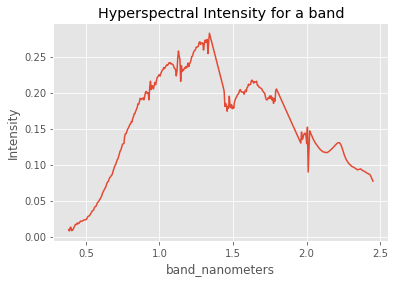

In [34]:
plot_hyper_bands(hyper_image, 25, 25)

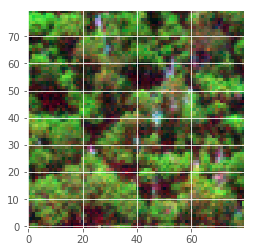

In [52]:
plot_hyper(another_image)

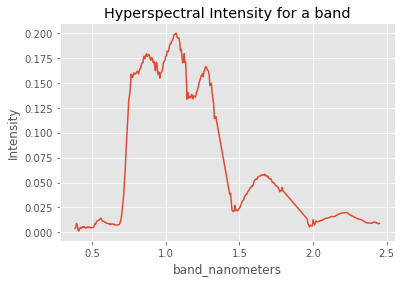

In [22]:
plot_hyper_bands(another_image, 40,25)

In [88]:
lidar_files[2], hyper_files[2]

('OSBS_003_chm.mat', 'OSBS_003_hyper.mat')

In [5]:
another_lidar = loadmat(LIDAR_FOLDER_PATH + lidar_files[2])['image'] 
another_hyper = loadmat(HYPER_FOLDER_PATH + hyper_files[2])['image']

In [6]:
plot_chm(another_lidar)
plot_hyper(another_hyper)


NameError: name 'plot_chm' is not defined

Min=408339.92,3285361.06 Max=408346.93,3285369.94
Min=408346.15,3285357.01 Max=408350.99,3285362.85
Min=408335.04,3285355.93 Max=408338.04,3285359.2
Min=408351.66,3285349.68 Max=408357.05,3285355.05
Min=408361.24,3285353.86 Max=408366.37,3285357.11
Min=408340.82,3285337.9 Max=408344.83,3285343.01
Min=408343.92,3285342.06 Max=408347.8,3285346.23


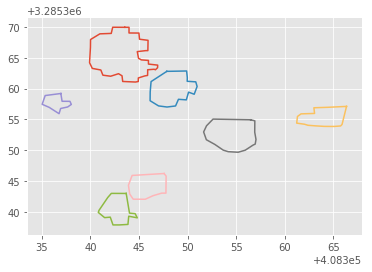

In [159]:
sf = shapefile.Reader("ITC_OSBS_003.shp")
g_min = float('-inf')
g_max = float('inf')
for shape in sf.shapes():
    x = np.round(np.array([i[0] for i in shape.points[:]]),2)
    y = np.round(np.array([i[1] for i in shape.points[:]]),2)
    plt.plot(x,y)
#     print("%r\n%r\n" %(x,y))
    print('Min=%r,%r Max=%r,%r' %(min(x), min(y), max(x), max(y)))
plt.show()

#Every 0.01 is a pixel f

## Thresholding LiDAR Heat Map 

In [131]:
# another_lidar = loadmat(LIDAR_FOLDER_PATH + lidar_files[2])['image'] 
def mask_lidar(lidar_image, threshold=0.25):
    lidar_image[lidar_image <= threshold] = 0
#     lidar_image[lidar_image > threshold] = 1
    return lidar_image 
# plot_chm(get_mask(another_lidar))

In [12]:
ndvi = loadmat('utils' + sep + 'data' + sep + 'ndvi.mat')['image']
print(ndvi, ndvi.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (10084, 9364)


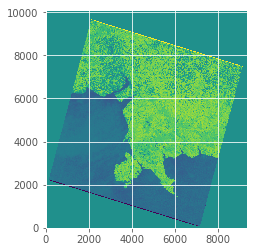

In [11]:
plt.imshow(ndvi,origin='lower')
plt.show()

1.0

(10084, 9364)


In [20]:
 
plot_hyper_bands(hyper_image, 10,15, wavelengths=trim_wavelengths[:364])

NameError: name 'hyper_image' is not defined

## Achievements
    - Hyperspectral Images (80x80x420) GeoTIFF Files 
        - Cast to .mat files 
        - Dimensionality Reduction (420 -> 364)
            - Purge Noisy Bands(Spikes in Intensities - provided with the dataset)
            - Smoothed out bands higher up in the spectrum using convolutions 
                - Discarded values from the last 5 bands for which intensitities were falling off in favor of averaged intensities from the previous bands 
    - LiDAR Images(80x80) GeoTiFF files
        - Cast to .mat files 
        - Easy Viewing 
    - PointCloud Data(20665x20665x20665)
        - Easy Viewing 


## In Progress 
    - Segmentation of LiDAR Images 

## Observations 
    - LiDAR Images 
        - Canopy Height Model(CHM)(80x80)
        - PointCloud Data(20665x20665x20665)
        
## Way Forward 
    - Segment LiDAR Images
        - Binary Cluster Labels? 
    - Segment HyperSpectral Images 
    - Use LiDAR segment labels as a Mask over the segmented hyper image 
    - NDVI calculated from the hypersepctral image 
    - Write it out into a shape file 
        - Jacqqaurd Constant to compare between the two 

## Asks 
### Correlation between Cluster out Labels and Test Shape Data 
    - How to generate shape output using algorithms' cluster label output? 
        - Output cluster labels are of the shape (80,80)
        - LiDAR PointCloud Data has the shape(20665,20665,20665)
            - How to map 80x80 to 20665x20665?

In [66]:
test_image = loadmat(DATASET_PATH + 'hs' + sep + 'MAT-EndBandsNotCleared' + sep +  hyper_files[3])['image']

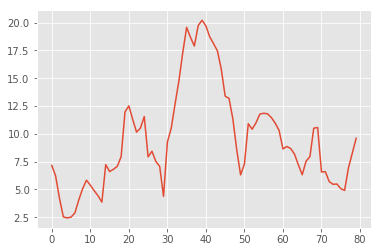

In [11]:
plt.plot(np.arange(0,80,1),another_lidar[40])

In [ ]:
#Mathematical Morphology Dilation - Local Max / Erosion - Local Max 